This notebook is an exercise in trying to predict primary production in the Westerscheldt from measurements of other data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
import pylab
from sklearn.ensemble import RandomForestRegressor
rands = 142
%matplotlib inline


In [2]:
def corrfunc(x, y, **kws):
    (r, p) = sps.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

def make_ts(var):
    return pd.Timestamp(var)

def make_datetime(var):
    return pd.Timestamp(var[0:10])

def make_month(var):
    return var.month

def make_hour(var):
    return var.hour

In [3]:
def make_station_df(df, station, threshold = 100):
    '''this function mades a Westerschelde station based on the proven workflow'''
    df = df[df['station'] == station]
    # df.drop(['latitude', 'longitude'], axis = 1, inplace = True)
    dfs_dict = {}
    threshold = 100
    try:
        df['date'] = df['datetime'].apply(make_datetime)
        df['datetime'] = df['datetime'].apply(make_ts)
        df['month'] = df['datetime'].apply(make_month)
        df['hour'] = df['datetime'].apply(make_hour)
        print('should not be longer than: ' + str(len(df['datetime'].unique())))
    except:
        pass
    # repurcussions of choosing date vs datetime as index...
    dff = pd.DataFrame(df['datetime'].unique())
    #dff = pd.DataFrame(df['date'].unique())

    dff['dummy'] = np.ones(len(dff))
    dff.set_index(0, inplace = True)

    for sub in df['aggName'].unique():
        dfs = df[df['aggName'] == sub][['datetime','value']]
        dfs.set_index('datetime', inplace = True)
        #dfs.set_index('date', inplace = True)
        dfs.sort_index(inplace = True)
        dfs.rename(columns = {'value' : sub}, inplace = True)
        if len(dfs) > threshold:
            print(sub)
            #print(len(dfs.index),len(dfs.index.unique()))
            if len(dfs.index) != len(dfs.index.unique()):
                # for each unique duplicated index, we assign the unique index
                # to be equal to he average of values at that index
                # there is so far no explanation for the duplicates
                for ind in dfs[dfs.index.duplicated()].index.unique():
                    vals = dfs.loc[ind]
                    vals[sub] = np.mean(vals[sub])
                    # now duplicate indicies will all have the same value, 
                    # and we can simply take the first
            dfs = dfs[~dfs.index.duplicated(keep='first')]
            dff = pd.concat((dff,dfs), axis = 1, ignore_index = False)
            dfs_dict[sub] = dfs
    return dff

In [4]:
station_train = 'Terneuzen boei 20'
station_test = 'Vlissingen'

In [5]:
df = pd.read_csv('./data/Westerscheldt/standarddata/Scheldemonitor_ASCII.csv')
df = df[df['station'] == station_train]
df.drop(['latitude', 'longitude'], axis = 1, inplace = True)

In [6]:
df.columns

Index(['station', 'depth', 'datetime', 'aggName', 'value', 'unit',
       'dataprovider'],
      dtype='object')

In [7]:
df['aggName'].unique()

array(['SPM', 'tP', 'Temp', 'KjN', 'Sal', 'NO2', 'NOX', 'Si', 'dP', 'O2',
       'DOC', 'NH4', 'COD', 'NO3', 'SO4', 'pN', 'POC', 'PO4', 'dN',
       'fpPO4', 'pSi', 'pPO4', 'Transparence', 'E', 'chlfa'], dtype=object)

Here we try to see if there is any information we can gather as to the source of the duplicates. <br>
for this we look at the unedited dataframe for the paramter tP at the values found at the second index which occurs more than once


In [8]:
tmp = df[df['aggName'] == 'tP']
tmp.set_index('datetime', inplace = True)
tmp.loc[tmp[tmp.index.duplicated()].index.unique()[1]]

,station,depth,aggName,value,unit,dataprovider
datetime,,,,,,
2000-08-21T10:32:00Z,Terneuzen boei 20,1.0,tP,0.600,mgP_l,RWS - Rijkswaterstaat
2000-08-21T10:32:00Z,Terneuzen boei 20,1.0,tP,0.139,mgP_l,RWS - Rijkswaterstaat


Everything is identical, even the time, except for the value. <br>
Is this the case for other parameters?

In [9]:
tmp = df[df['aggName'] == 'NO3']
tmp.set_index('datetime', inplace = True)
tmp.loc[tmp[tmp.index.duplicated()].index.unique()[1]]

,station,depth,aggName,value,unit,dataprovider
datetime,,,,,,
2000-08-21T10:32:00Z,Terneuzen boei 20,1.0,NO3,7.10,mgN_l,RWS - Rijkswaterstaat
2000-08-21T10:32:00Z,Terneuzen boei 20,1.0,NO3,1.39,mgN_l,RWS - Rijkswaterstaat


In [10]:
df

,station,depth,datetime,aggName,value,unit,dataprovider
4,Terneuzen boei 20,1.0,1983-04-05T11:33:00Z,SPM,26.00,mg_l,RWS - Rijkswaterstaat
9,Terneuzen boei 20,1.0,1977-04-25T11:28:00Z,tP,0.26,mgP_l,RWS - Rijkswaterstaat
10,Terneuzen boei 20,1.0,1977-05-09T12:00:00Z,tP,0.25,mgP_l,RWS - Rijkswaterstaat
11,Terneuzen boei 20,1.0,1977-05-23T10:50:00Z,tP,0.17,mgP_l,RWS - Rijkswaterstaat
343,Terneuzen boei 20,1.0,1987-09-07T09:47:00Z,tP,0.39,mgP_l,RWS - Rijkswaterstaat
344,Terneuzen boei 20,NaN,1988-03-17T08:12:00Z,Temp,5.50,C,RWS - Rijkswaterstaat
352,Terneuzen boei 20,1.0,1990-01-29T08:38:00Z,KjN,0.78,mgN_l,RWS - Rijkswaterstaat
360,Terneuzen boei 20,1.0,2000-06-20T02:00:00Z,tP,0.50,mgP_l,RWS - Rijkswaterstaat
361,Terneuzen boei 20,1.0,2000-07-24T02:00:00Z,tP,0.20,mgP_l,RWS - Rijkswaterstaat
362,Terneuzen boei 20,1.0,2000-08-21T10:32:00Z,tP,0.60,mgP_l,RWS - Rijkswaterstaat


Yes, and the duplicate occurs on the same day. We will assume for now that it is a duplicate measurement. The numbers are quite different which is suspicious.

Now we will make a dataframe where the columns are features. <br>
To do this we will make an empty data frame with indicies representing all measured times. <br>
we will then go through each substance and make a dataframe of those times and the substance values. Following this we will concatenate this with the growing data frame.

In [11]:
## refactored
dff = make_station_df(df, station_train)

should not be longer than: 1193
SPM
tP
Temp
KjN
Sal
NO2
NOX
Si
dP
O2
DOC
NH4
NO3
SO4
pN
POC
PO4
dN
pPO4
Transparence
E
chlfa


In [12]:
dff

,dummy,SPM,tP,Temp,KjN,Sal,NO2,NOX,Si,dP,...,NO3,SO4,pN,POC,PO4,dN,pPO4,Transparence,E,chlfa
1967-02-07 10:40:00+00:00,1.0,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1000,NaN,NaN,NaN,NaN,NaN
1967-02-20 12:00:00+00:00,1.0,NaN,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1600,NaN,NaN,NaN,NaN,NaN
1967-03-06 15:00:00+00:00,1.0,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1300,NaN,NaN,NaN,NaN,NaN
1967-04-05 11:00:00+00:00,1.0,NaN,NaN,7.50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1000,NaN,NaN,NaN,NaN,NaN
1967-04-19 13:10:00+00:00,1.0,NaN,NaN,9.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0600,NaN,NaN,NaN,NaN,NaN
1967-05-08 15:45:00+00:00,1.0,NaN,NaN,10.50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1000,NaN,NaN,NaN,NaN,NaN
1967-05-17 11:55:00+00:00,1.0,NaN,NaN,12.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1000,NaN,NaN,NaN,NaN,NaN
1967-05-31 15:10:00+00:00,1.0,NaN,NaN,14.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967-06-19 15:00:00+00:00,1.0,NaN,NaN,16.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.2000,NaN,NaN,NaN,NaN,NaN
1967-07-05 10:55:00+00:00,1.0,NaN,NaN,18.50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If we use all of these features, how many data points do we have?

In [13]:
len(dff.dropna(axis = 0))

54

This is too few points. We need to remove some objects. Let's sort by richness of data.

In [14]:
np.array([100 * dff.isnull().sum()/len(dff)])

array([[ 0.        , 43.6714166 , 53.98155909, 22.9673093 , 67.97988265,
        58.59178541, 45.85079631, 32.43922883, 41.82732607, 73.67979883,
        24.30846605, 61.6093881 , 27.07460184, 45.85079631, 91.19865884,
        73.34450964, 62.69907795, 37.13327745, 73.26068734, 73.34450964,
        54.98742666, 83.57082984, 53.64626991]])

In [15]:
features = pd.Series(np.array(dff.isnull().sum()/len(dff)), list(dff.columns))

In [16]:
features = features.sort_values()

Text(0, 0.5, '% of null point')

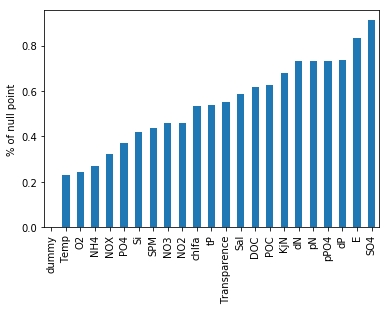

In [17]:
features.plot.bar()
plt.ylabel('% of null point')

Now we select features based on a richness threshold and check resulting richness. We will set the threhsold to be those where more than 60% of days are non NULL.

/home/rudy/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


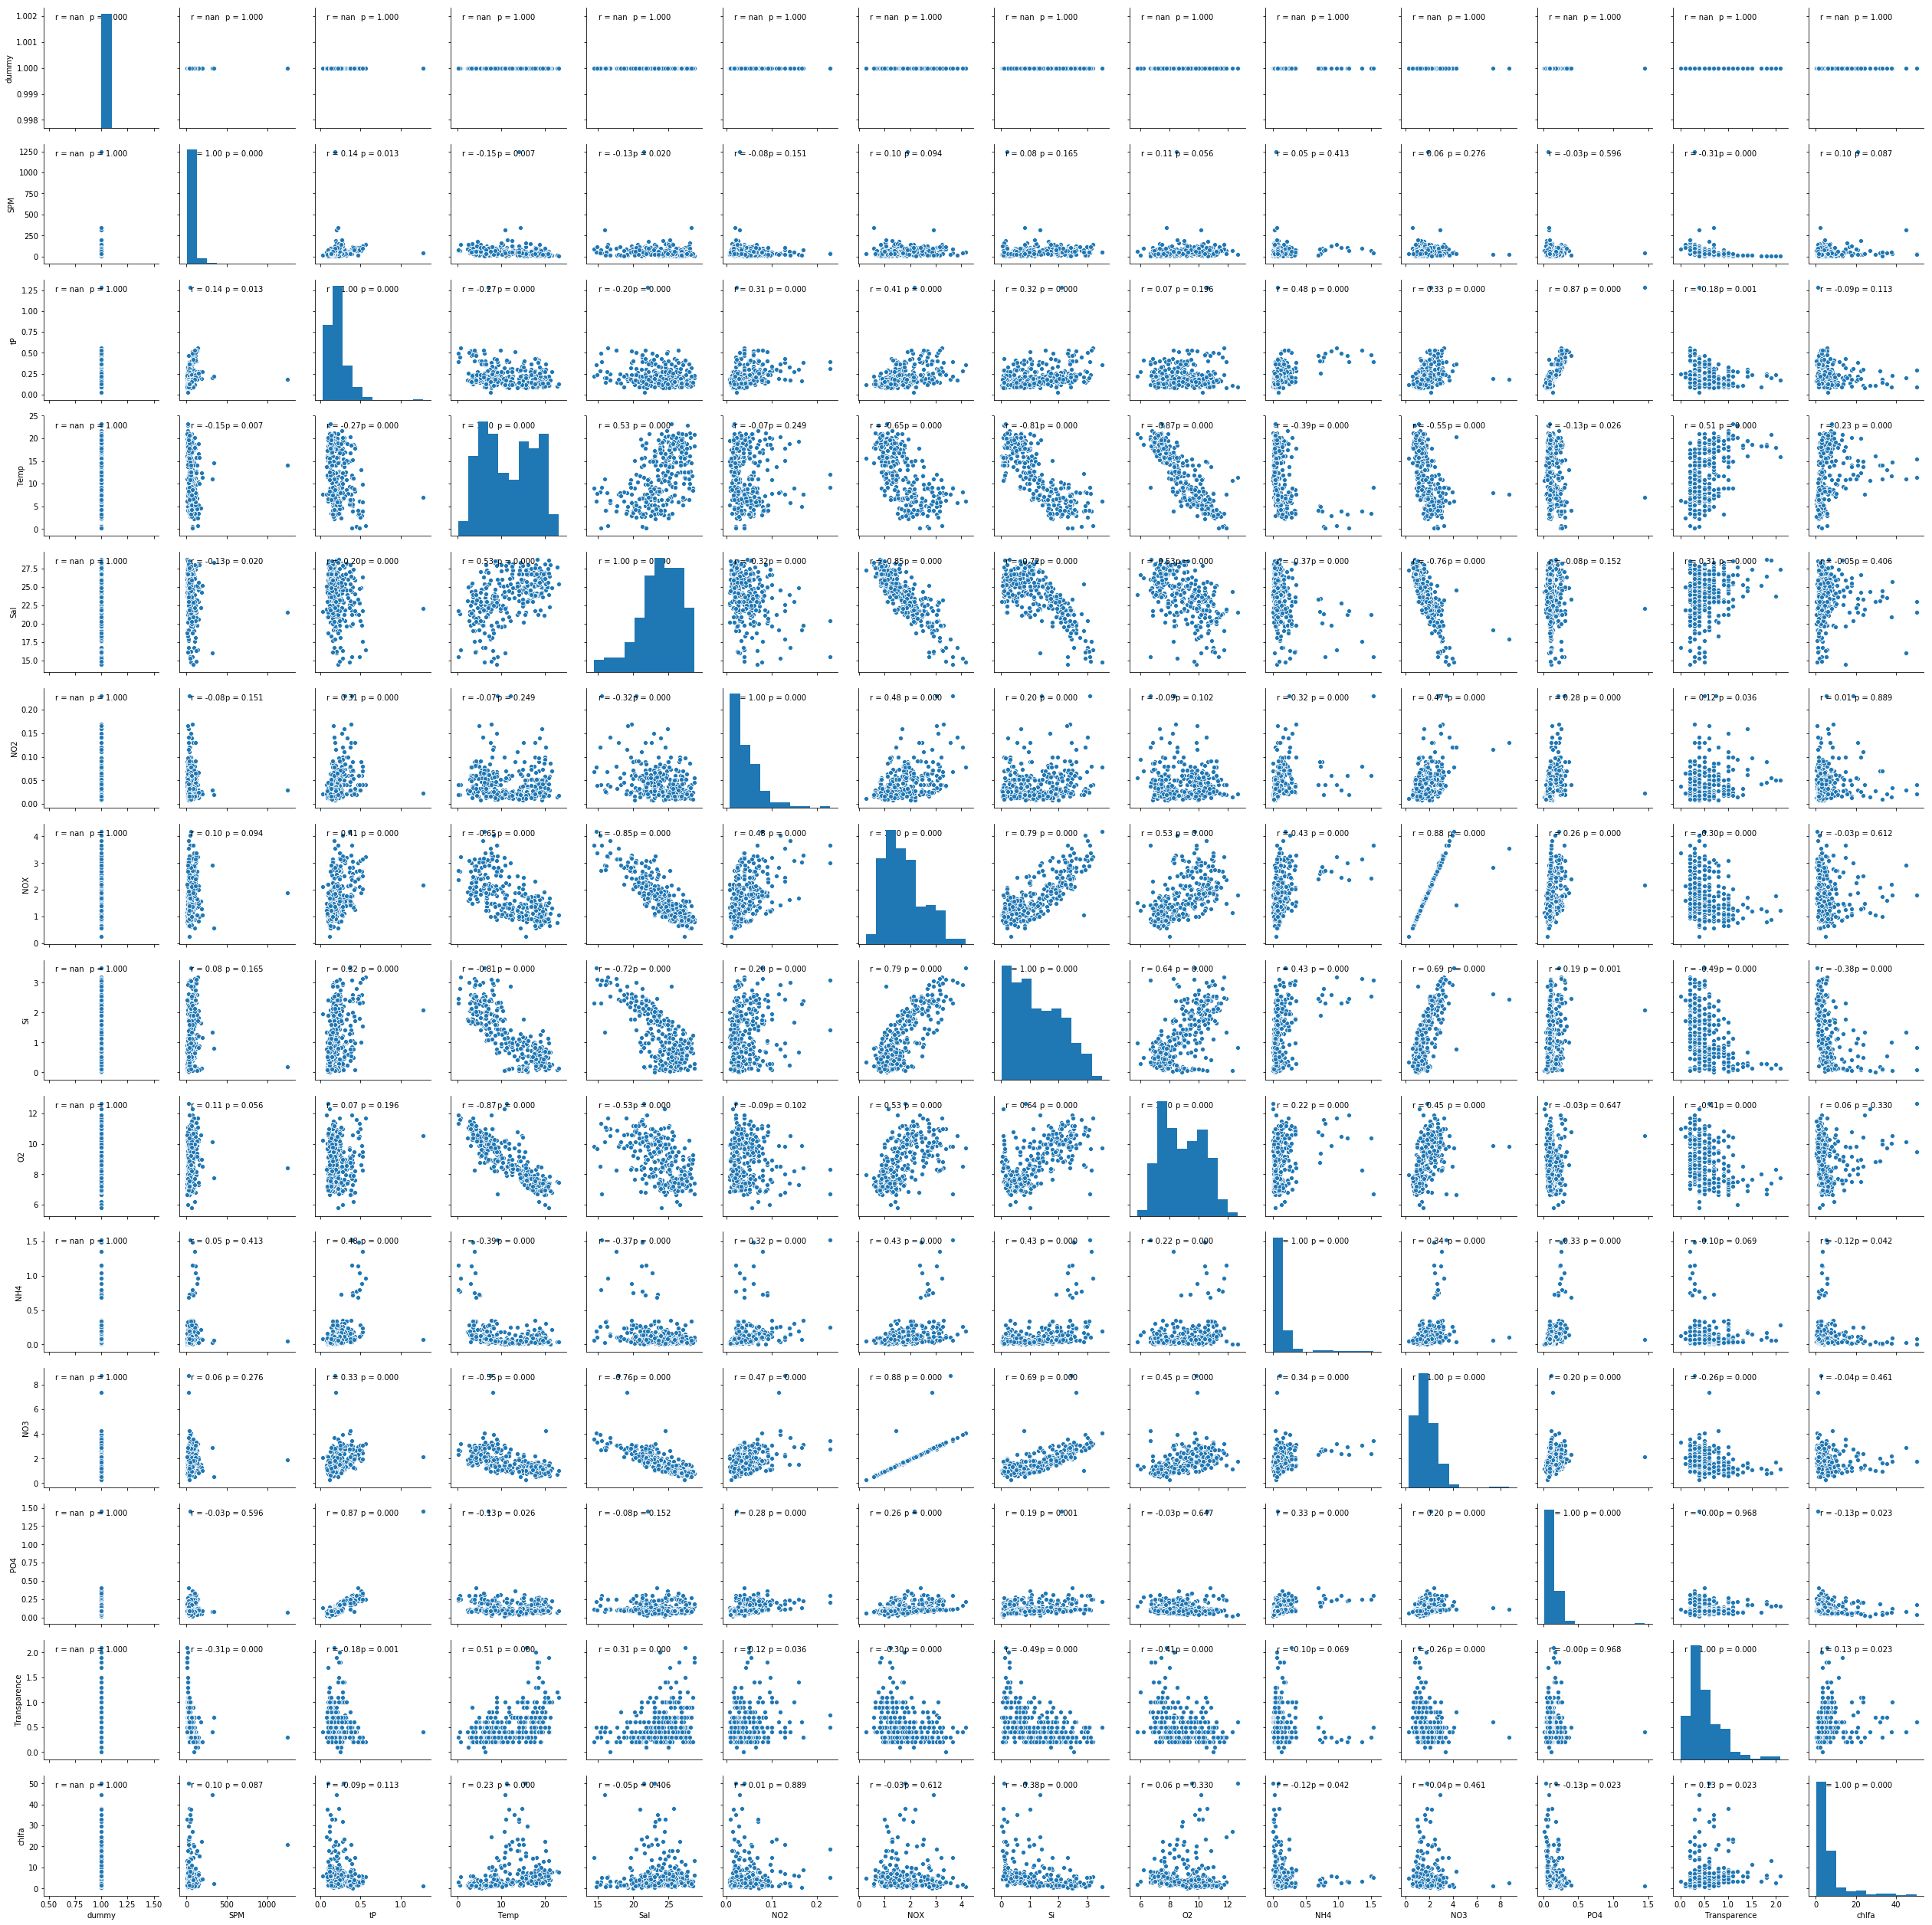

In [18]:
drop_features = features[features > 0.6].index
prplt = sns.pairplot(dff.drop(drop_features, axis = 1).dropna())
prplt.map(corrfunc)

In [60]:
prplt.savefig('pairplot.png', dpi = 800)

Text(0.5, 1.0, 'chlorophyll-a')

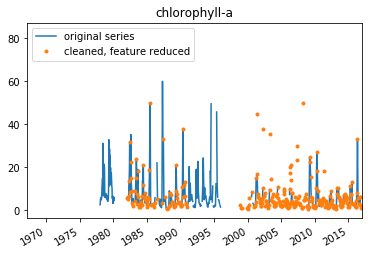

In [19]:
dff['chlfa'].plot(label = 'original series')
plt.plot(dff.drop(drop_features, axis = 1).dropna()['chlfa'], '.',label = 'cleaned, feature reduced')
plt.legend()
plt.title('chlorophyll-a')


Now we will try a random forest regressor

In [20]:
rf = RandomForestRegressor(n_estimators=1000, max_depth = 5, random_state = rands)

In [21]:
Y_test = dff.drop(drop_features, axis = 1).dropna().pop('chlfa')

In [22]:
X_test = dff.drop(drop_features, axis = 1).dropna().drop(['chlfa','dummy'], axis = 1)

In [23]:
rf.fit(X_test, Y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=142, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

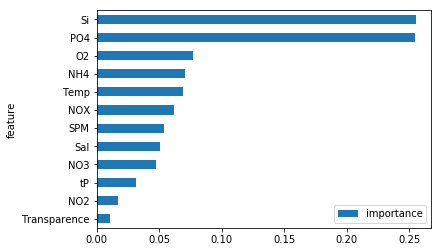

In [24]:
feature_importance_data = []

for feature_name, feature_importance in zip(X_test.columns, rf.feature_importances_):
    feature_importance_data.append({'feature' : feature_name, 'importance' : feature_importance})
feature_importance_data = pd.DataFrame(feature_importance_data)

plt.figure(2)
ax = feature_importance_data.sort_values(by = 'importance').plot(kind = 'barh', y = 'importance', x = 'feature')


In [78]:
rf.feature_importances_


array([0.0534774 , 0.03151407, 0.06909912, 0.05030853, 0.01738399,
       0.06173989, 0.25496125, 0.07716763, 0.07098054, 0.04777116,
       0.25476875, 0.01082766])

In [77]:
features.index


Index(['dummy', 'Temp', 'O2', 'NH4', 'NOX', 'PO4', 'Si', 'SPM', 'NO3', 'NO2',
       'chlfa', 'tP', 'Transparence', 'Sal', 'DOC', 'POC', 'KjN', 'dN', 'pN',
       'pPO4', 'dP', 'E', 'SO4'],
      dtype='object')